## imports and utility functions

In [2]:
!pip install torch

  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.8.0-cp311-cp311-win_amd64.whl (241.4 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)

  Attempting uninstall: sympy

    Found existing installation: sympy 1.13.1

   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
    Uninstalling sympy-1.13.1:
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   -------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.89 requires torchvision>=0.9.0, which is not installed.


In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For molecules
from rdkit import Chem
from rdkit.Chem import AllChem

# Optional: PyTorch Geometric (message passing)
try:
    from torch_geometric.data import Data as GeometricData
    from torch_geometric.nn import GINConv, global_add_pool, MessagePassing
    from torch_geometric.loader import DataLoader as GeoDataLoader
    pyg_available = True
except Exception as e:
    print("PyG not available:", e)
    pyg_available = False

# Sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Featurize molecule into graph (RDKit -> node features, edge index)

In [2]:
# Atom feature builder (simple and effective)
ATOM_LIST = ["C","O","N","S","F","Cl","Br","I","P","H","B","Si","Se","other"]

def atom_to_feature(atom):
    # returns a numeric vector for an RDKit atom
    atom_symbol = atom.GetSymbol()
    atom_onehot = [1 if atom_symbol==a else 0 for a in ATOM_LIST]
    if sum(atom_onehot) == 0:
        atom_onehot[-1] = 1  # 'other'
    degree = atom.GetDegree()
    formal_charge = atom.GetFormalCharge()
    aromatic = 1 if atom.GetIsAromatic() else 0
    implicit_h = atom.GetTotalNumHs()
    hybrid = atom.GetHybridization().real if hasattr(atom.GetHybridization(), 'real') else int(atom.GetHybridization())
    return np.array(atom_onehot + [degree, formal_charge, aromatic, implicit_h, hybrid], dtype=float)

def mol_to_graph_data_obj(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # sanitize & kekulize if needed
    Chem.Kekulize(mol, clearAromaticFlags=True) if mol.GetNumAtoms()>0 else None
    node_feats = []
    for atom in mol.GetAtoms():
        node_feats.append(atom_to_feature(atom))
    node_feats = np.vstack(node_feats).astype(np.float32)

    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        edge_index.append([a1, a2])
        edge_index.append([a2, a1])
        bt = bond.GetBondType()
        # simple bond type encoding
        bond_type = [int(bt==Chem.rdchem.BondType.SINGLE), int(bt==Chem.rdchem.BondType.DOUBLE),
                     int(bt==Chem.rdchem.BondType.TRIPLE), int(bt==Chem.rdchem.BondType.AROMATIC)]
        edge_attr.append(bond_type)
        edge_attr.append(bond_type)
    if len(edge_index)==0:
        edge_index = np.zeros((2,0), dtype=int)
        edge_attr = np.zeros((0,4), dtype=float)
    else:
        edge_index = np.array(edge_index).T  # 2 x E
        edge_attr = np.array(edge_attr, dtype=float)
    return {
        "x": node_feats,        # (N_nodes, feat_dim)
        "edge_index": edge_index,
        "edge_attr": edge_attr,
        "num_nodes": node_feats.shape[0]
    }

## protein encoding

In [3]:
# Option A: simple amino acid index embedding + 1D CNN (fast)
AA_LIST = "ACDEFGHIKLMNPQRSTVWY"
aa2idx = {a:i+1 for i,a in enumerate(AA_LIST)}  # reserve 0 for padding

def seq_to_index(seq, max_len=1000):
    seq = seq[:max_len]
    idxs = [aa2idx.get(c, 0) for c in seq]   # unknown AA -> 0
    return np.array(idxs, dtype=int)

# Option B (recommended for better performance): use precomputed ESM or ProtTrans embeddings.
# That requires heavy models and disk space; treat ESM embeddings as optional later step.

## dataset class (for PyG if availabe, else fallback)

In [4]:
class DTIDataset(Dataset):
    def __init__(self, df_pairs, df_drugs, df_proteins, drug_smiles_col='Canonical_SMILES', prot_seq_col='Sequence', max_seq_len=1000):
        """
        df_pairs: dataframe with Drug_Index, Protein_Index, Affinity
        df_drugs: dataframe with Drug_Index, Canonical_SMILES
        df_proteins: dataframe with Protein_Index, Sequence
        """
        self.pairs = df_pairs.reset_index(drop=True)
        self.drug_map = df_drugs.set_index('Drug_Index')[drug_smiles_col].to_dict()
        self.protein_map = df_proteins.set_index('Protein_Index')[prot_seq_col].to_dict()
        self.max_seq_len = max_seq_len
        self.graph_cache = {}  # cache mol graphs to avoid recompute

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        r = self.pairs.loc[idx]
        d_idx = r['Drug_Index']
        p_idx = r['Protein_Index']
        y = float(r['Affinity'])

        smiles = self.drug_map[d_idx]
        seq = self.protein_map[p_idx]

        # mol graph
        if smiles not in self.graph_cache:
            g = mol_to_graph_data_obj(smiles)
            if g is None:
                # handle failures by using an empty graph representation
                g = {"x": np.zeros((1, len(ATOM_LIST)+5), dtype=float), "edge_index": np.zeros((2,0),dtype=int), "edge_attr": np.zeros((0,4),dtype=float), "num_nodes": 1}
            self.graph_cache[smiles] = g
        g = self.graph_cache[smiles]

        # protein indices
        seq_idx = seq_to_index(seq, max_len=self.max_seq_len)
        # pad sequence
        if len(seq_idx) < self.max_seq_len:
            pad = np.zeros(self.max_seq_len - len(seq_idx), dtype=int)
            seq_idx = np.concatenate([seq_idx, pad])

        # prepare torch tensors
        mol_x = torch.tensor(g['x'], dtype=torch.float)
        edge_index = torch.tensor(g['edge_index'], dtype=torch.long)
        edge_attr = torch.tensor(g['edge_attr'], dtype=torch.float)
        prot_idx = torch.tensor(seq_idx, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.float)

        return mol_x, edge_index, edge_attr, prot_idx, y

## GNN encoder + protein encoder + joint MLP

In [5]:
# Define amino acid vocabulary
AA_LIST = [
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
    'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'
]
AA_TO_IDX = {aa: i+1 for i, aa in enumerate(AA_LIST)}  # +1 so that 0 = padding

In [21]:
# Example GNN encoder using simple GIN blocks (PyG required)
if pyg_available:
    from torch_geometric.nn import GINConv, global_add_pool
    class GNNEncoder(nn.Module):
        def __init__(self, in_dim, hidden_dim=128, n_layers=3, dropout=0.3):
            super().__init__()
            self.convs = nn.ModuleList()
            self.batch_norms = nn.ModuleList()
            self.drop = nn.Dropout(dropout)
            for i in range(n_layers):
                mlp = nn.Sequential(
                    nn.Linear(in_dim if i==0 else hidden_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim)
                )
                conv = GINConv(mlp)
                self.convs.append(conv)
                self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            self.pool = global_add_pool

        def forward(self, x, edge_index, batch):
            h = x
            for conv, bn in zip(self.convs, self.batch_norms):
                h = conv(h, edge_index)
                h = bn(h)
                h = torch.relu(h)
                h = self.drop(h)   # <-- dropout inside GNN
            # global pooling
            g = self.pool(h, batch)
            return g

# Protein encoder with dropout
class ProteinEncoder(nn.Module):
    def __init__(self, vocab_size=len(AA_LIST)+1, emb_dim=50, out_dim=128, max_len=1000, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(emb_dim, 128, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(out_dim)
        
        self.conv2 = nn.Conv1d(128, out_dim, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(out_dim)
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.drop = nn.Dropout(dropout)

    def forward(self, seq_idx):
        # seq_idx: (batch, seq_len)
        x = self.embed(seq_idx)            # (B, L, emb)
        x = x.permute(0,2,1)               # (B, emb, L)

        # conv1 -> BN -> ReLU
        x = torch.relu(self.bn1(self.conv1(x)))

        # conv2 -> BN -> ReLU -> Dropout
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.drop(x)
        
        x = self.pool(x).squeeze(-1)       # (B, out_dim)
        return x

# Final joint model
class DTIModel(nn.Module):
    def __init__(self, molecule_feat_dim, gnn_hidden=128, prot_out_dim=128, final_hidden=256):
        super().__init__()
        if pyg_available:
            self.gnn = GNNEncoder(in_dim=molecule_feat_dim, hidden_dim=gnn_hidden, dropout=0.3)
        else:
            # fallback: simple MLP on atom mean
            self.gnn = nn.Sequential(
                nn.Linear(molecule_feat_dim, gnn_hidden), 
                nn.ReLU(), 
                nn.Dropout(0.3),
                nn.Linear(gnn_hidden, gnn_hidden)
            )
        self.prot_enc = ProteinEncoder(out_dim=prot_out_dim, dropout=0.3)
        self.head = nn.Sequential(
            nn.Linear(gnn_hidden + prot_out_dim, final_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(final_hidden, 1)  # regression output
        )

    def forward(self, mol_x, edge_index, batch_index, prot_idx):
        # mol_x: node features across batch concatenated in PyG format
        if pyg_available:
            drug_emb = self.gnn(mol_x, edge_index, batch_index)  # (B, gnn_hidden)
        else:
            drug_emb = mol_x.mean(dim=1)
        prot_emb = self.prot_enc(prot_idx)
        x = torch.cat([drug_emb, prot_emb], dim=1)
        out = self.head(x).squeeze(-1)
        return out

## collate function + DataLoader (PyG path and basic path)

In [7]:
# For PyG: convert each sample to GeometricData and use GeoDataLoader
from torch_geometric.data import Data as GeoData

def to_pyg_data_list(dataset):
    data_list = []
    for i in range(len(dataset)):
        mol_x, edge_index, edge_attr, prot_idx, y = dataset[i]
        data = GeoData(x=mol_x, edge_index=edge_index, edge_attr=edge_attr, y=y.unsqueeze(0))
        data.prot_idx = prot_idx  # attach protein sequence indices
        data_list.append(data)
    return data_list

# Custom collate for DataLoader if not using GeoDataLoader
def collate_fn(batch):
    mol_xs, edge_idxs, edge_attrs, prot_idxs, ys = zip(*batch)
    # For plain DataLoader baseline: stack protein indices and average mol features as fallback
    prot_idxs = torch.stack(prot_idxs)
    ys = torch.stack(ys)
    # create mol tensor: mean over nodes for each molecule
    mol_mean = torch.stack([mx.mean(dim=0) for mx in mol_xs])
    return mol_mean, prot_idxs, ys

## training loop

In [8]:
def train_epoch(model, loader, optimizer, device, loss_fn, clip_norm=5.0):
    model.train()
    total_loss = 0
    for batch in loader:
        if pyg_available:
            batch = batch.to(device)
            prot_idx = torch.stack([d.prot_idx for d in batch.to_data_list()]).to(device)
            pred = model(batch.x, batch.edge_index, batch.batch, prot_idx)
            y = batch.y.to(device).float()
        else:
            mol_x, edge_idx, batch_vec, prot_idx, y = [x.to(device) for x in batch]
            pred = model(mol_x, edge_idx, batch_vec, prot_idx)

        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, dataloader, device):
    model.eval()
    ys = []
    preds = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            if pyg_available and isinstance(batch, GeoData):
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.batch, batch.prot_idx.to(batch.x.device))
                y = batch.y.cpu().numpy()
            else:
                mol_mean, prot_idxs, y = batch
                pred = model(mol_mean.to(device).float(), None, None, prot_idxs.to(device).long())
                y = y.cpu().numpy()
                pred = pred.cpu().numpy()
            preds.append(pred.reshape(-1))
            ys.append(y.reshape(-1))
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    rmse = np.sqrt(mean_squared_error(ys, preds))
    r2 = r2_score(ys, preds)
    return {"rmse": rmse, "r2": r2}

## Putting it together: create dataset, dataloaders, model, run a small experiment

In [22]:
# Load dataframes (paths you already have)
df_drugs = pd.read_csv('drugs.csv')
df_proteins = pd.read_csv('proteins.csv')
df_affinity = pd.read_csv('drug_protein_affinity.csv')

# quick train/test split (random)
train_df, test_df = train_test_split(df_affinity, test_size=0.1, random_state=42)

train_ds = DTIDataset(train_df, df_drugs, df_proteins, max_seq_len=512)
test_ds = DTIDataset(test_df, df_drugs, df_proteins, max_seq_len=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if pyg_available:
    # build PyG data objects
    train_list = to_pyg_data_list(train_ds)
    test_list = to_pyg_data_list(test_ds)
    train_loader = GeoDataLoader(train_list, batch_size=32, shuffle=True)
    test_loader = GeoDataLoader(test_list, batch_size=32, shuffle=False)

    molecule_feat_dim = train_ds.graph_cache[next(iter(train_ds.graph_cache))]['x'].shape[1]
    model = DTIModel(molecule_feat_dim=molecule_feat_dim).to(device)

    # patched versions of train/eval to collate prot_idx
    def train_epoch(model, loader, optimizer, device):
        model.train()
        total_loss = 0
        for batch in loader:
            batch = batch.to(device)
            # stack protein indices into a proper batch tensor
            prot_idx = torch.stack([d.prot_idx for d in batch.to_data_list()]).to(device)
            pred = model(batch.x, batch.edge_index, batch.batch, prot_idx)
            y = batch.y.to(device).float()
            loss = torch.nn.functional.mse_loss(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

    def evaluate(model, loader, device):
        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)
                prot_idx = torch.stack([d.prot_idx for d in batch.to_data_list()]).to(device)
                pred = model(batch.x, batch.edge_index, batch.batch, prot_idx)
                y = batch.y.to(device).float()
                preds.append(pred.cpu())
                labels.append(y.cpu())
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        rmse = torch.sqrt(torch.nn.functional.mse_loss(preds, labels)).item()
        r2 = r2_score(labels.numpy(), preds.numpy())
        return {"rmse": rmse, "r2": r2}

else:
    # fallback: plain tensors
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
    sample_mol, _, _, _, _ = train_ds[0]
    molecule_feat_dim = sample_mol.shape[1]
    model = DTIModel(molecule_feat_dim=molecule_feat_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# quick training run
for epoch in range(1, 201):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_metrics = evaluate(model, test_loader, device)
    print(f"Epoch {epoch} — train_loss: {train_loss:.4f} — val_rmse: {val_metrics['rmse']:.4f} — val_r2: {val_metrics['r2']:.4f}")

Epoch 1 — train_loss: 1.1167 — val_rmse: 1.3466 — val_r2: -1.5320
Epoch 2 — train_loss: 0.7968 — val_rmse: 1.5036 — val_r2: -2.1571
Epoch 3 — train_loss: 0.7872 — val_rmse: 1.4964 — val_r2: -2.1268
Epoch 4 — train_loss: 0.7669 — val_rmse: 1.5411 — val_r2: -2.3162
Epoch 5 — train_loss: 0.7471 — val_rmse: 1.5182 — val_r2: -2.2185
Epoch 6 — train_loss: 0.7416 — val_rmse: 1.6639 — val_r2: -2.8662
Epoch 7 — train_loss: 0.7280 — val_rmse: 1.4957 — val_r2: -2.1239
Epoch 8 — train_loss: 0.6942 — val_rmse: 0.9496 — val_r2: -0.2592
Epoch 9 — train_loss: 0.6775 — val_rmse: 1.4285 — val_r2: -1.8497
Epoch 10 — train_loss: 0.6616 — val_rmse: 1.2843 — val_r2: -1.3033
Epoch 11 — train_loss: 0.6554 — val_rmse: 1.4557 — val_r2: -1.9590
Epoch 12 — train_loss: 0.6407 — val_rmse: 1.0057 — val_r2: -0.4123
Epoch 13 — train_loss: 0.6379 — val_rmse: 1.4969 — val_r2: -2.1291
Epoch 14 — train_loss: 0.6380 — val_rmse: 1.2800 — val_r2: -1.2879
Epoch 15 — train_loss: 0.6070 — val_rmse: 1.3608 — val_r2: -1.5857
Epoc

## Eval

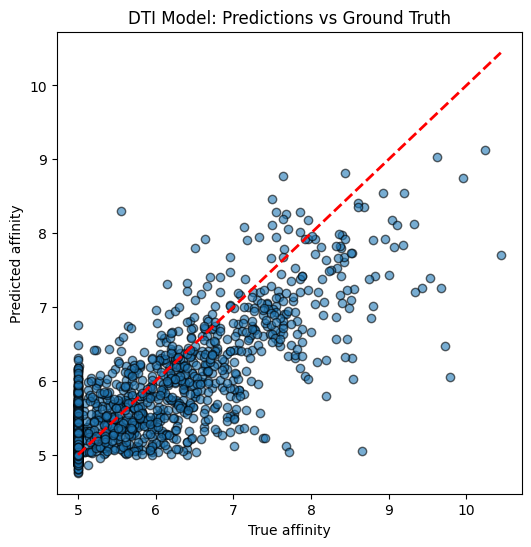

In [23]:
import matplotlib.pyplot as plt

# Collect predictions on test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        if pyg_available:
            batch = batch.to(device)
            prot_idx = torch.stack([d.prot_idx for d in batch.to_data_list()]).to(device)
            preds = model(batch.x, batch.edge_index, batch.batch, prot_idx)
            y = batch.y.to(device).float()
        else:
            mol_x, edge_idx, batch_vec, prot_idx, y = [x.to(device) for x in batch]
            preds = model(mol_x, edge_idx, batch_vec, prot_idx)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(all_labels, all_preds, alpha=0.6, edgecolor='k')
plt.plot([all_labels.min(), all_labels.max()],
         [all_labels.min(), all_labels.max()],
         'r--', lw=2)  # diagonal
plt.xlabel("True affinity")
plt.ylabel("Predicted affinity")
plt.title("DTI Model: Predictions vs Ground Truth")
plt.show()